In [1]:
# %reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline

%load_ext Cython



In [2]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_8000a7727c451ae88844bdd9f9cbdcc9.c:775:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [3]:
# %pip install Pylians
from tqdm import tqdm
# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
# root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
root_z0 = '/mnt/home/spandey/ceph/Quijote/pmwd/z0/'
root_z99 = '/mnt/home/spandey/ceph/Quijote/pmwd/z99/'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_pmwd_LH/'
# ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
grids         = [128]
# grids         = [128, 256]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
# n_cnn_all = [0,4,6,8,12,16]
n_cnn_all = [0,4]
# n_sim_tot = 2

# n_sim_array = np.arange(0,551)
n_sim_array = np.arange(513,551)
# n_sim_array = np.arange(512, 528)
# n_sim_array = np.arange(528, 600)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,4]
# snap_num_array = [-1]
snap_num_array = [4]
# snap_num_array = [-1]
# i = 0
# print(i)
for ji in tqdm(n_sim_array):
    # print('doing sim: ' + str(ji))
    for grid in grids:
        # print('doing res: ' + str(grid))
        for snapnum in snap_num_array:
            z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 99}[snapnum]

            # create output folder if it does not exists
            folder_out = '%s/%d'%(root_out,ji)
            if not(os.path.exists(folder_out)):
                os.system('mkdir %s'%folder_out)

            
            savefname_halos_subvol = '%s/halos_HR_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
            savefname_halos_full = '%s/halos_HR_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
            
            # compute the density field and save it to file
            if snapnum > 0:
                # snapshot = '%s'%(root_z0)
                snapshot = '%s/rho_%d.npy' % (root_z0, ji)
                df_cic = np.load(snapshot)                
            else:
                snapshot = '%s/%d' % (root_z99, ji)
                df_cic = np.load('%s/rho.npy'%(snapshot))
            df_pylians_cic = df_cic
            # df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0

            # df_ngp = df_cic
            # df_pylians_ngp = df_pylians_cic                      
            


            for n_cnn in n_cnn_all:
                # find name of output file
                savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                n_dim_red = (n_filter - 1) // 2
                n_pad = n_dim_red * n_cnn
                if n_cnn > 0:
                    df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                    # df_uniform_cic_pad = np.pad(df_uniform_cic_jax, n_pad, 'wrap')
                    # df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
                else:
                    df_cic_pad = df_pylians_cic
                    # df_uniform_cic_pad = df_uniform_cic_jax
                    # df_ngp_pad = df_pylians_ngp

                # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                xstart, ystart, zstart = n_pad, n_pad, n_pad
                subvol_size = grid // n_batch + 2 * n_pad
                nsubvol = n_batch**3
                save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                jc = 0
                from tqdm import tqdm
                for jx in (range(n_batch)):
                    for jy in range(n_batch):
                        for jz in range(n_batch):
                            # get the sub-cube
                            df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                            ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                            zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # save the sub-cube
                            save_subvol_density_cic_pad[jc, ...] = df_sub

                            # df_sub = df_uniform_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                            #                 ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                            #                 zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # # save the sub-cube
                            # save_subvol_density_uniform_cic_pad[jc, ...] = df_sub


                            # df_sub = df_ngp_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                            #                 ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                            #                 zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # # save the sub-cube
                            # save_subvol_density_ngp_pad[jc, ...] = df_sub

                            jc += 1

                subvol_size = grid // n_batch
                nsubvol = n_batch**3
                save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                jc = 0
                
                for jx in (range(n_batch)):
                    for jy in range(n_batch):
                        for jz in range(n_batch):
                            # get the sub-cube
                            save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                                           jy * subvol_size:(jy + 1) * subvol_size,
                                                           jz * subvol_size:(jz + 1) * subvol_size]
                            
                            # save_subvol_density_uniform_cic_unpad[jc] = df_uniform_cic_jax[jx * subvol_size:(jx + 1) * subvol_size,
                            #                                   jy * subvol_size:(jy + 1) * subvol_size,
                            #                                     jz * subvol_size:(jz + 1) * subvol_size]
                            
                            
                            # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                            #                                jy * subvol_size:(jy + 1) * subvol_size,
                            #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                            jc += 1


                saved_density_subvol = {
                    'density_cic_pad':save_subvol_density_cic_pad,
                    # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                    # 'density_ngp_pad':save_subvol_density_ngp_pad,
                    'density_cic_unpad':save_subvol_density_cic_unpad,
                    # 'density_ngp_unpad':save_subvol_density_ngp_unpad,
                    # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad
                    }                        

                pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                saved_density_full = {
                    'density_cic_unpad_combined':df_pylians_cic,
                    # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                    # 'density_ngp_unpad_combined':df_pylians_ngp,                                
                    'density_cic_pad_combined':df_cic_pad,
                    # 'density_ngp_pad_combined':df_ngp_pad,
                    # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                                            
                    }                        

                pk.dump(saved_density_full, open(savefname_density_full, 'wb'))





                


  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 38/38 [00:12<00:00,  3.06it/s]


In [8]:
# FOR ROCKSTAR HALOS:

# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
# root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# mass_types = ['fof','rockstar_200c','rockstar_vir']
mass_types = ['rockstar_200c']
# mass_types = ['fof']
# Mmin_cut = 7e12
# Mmin_cut_str = '7e12'

Mmin_cut = 1e13
Mmin_cut_str = '1e13'

# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
# root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_pmwd_LH/'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
grids         = [128]
# grids         = [128, 256]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
# n_cnn_all = [2,4]
# n_cnn_all = [12,16]
n_cnn_all = [0,4]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
# n_sim_array = np.arange(0,16)
# n_sim_array = np.arange(0,20)
# n_sim_array = np.arange(10,350)
# n_sim_array = np.arange(351,512)
# n_sim_array = np.array([350])
# n_sim_array = np.arange(528, 600)
# n_sim_array = np.arange(0,551)
n_sim_array = np.arange(0,540)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,4]
snap_num_array = [4]
# snap_num_array = [-1]
# i = 0
# print(i)
for mass_type in mass_types:
    print('doing mass type: ' + str(mass_type))
    for ji in n_sim_array:
        print('doing sim: ' + str(ji))
        for grid in grids:
            # print('doing res: ' + str(grid))
            for snapnum in snap_num_array:
                z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

                # create output folder if it does not exists
                folder_out = '%s/%d'%(root_out,ji)
                if not(os.path.exists(folder_out)):
                    os.system('mkdir %s'%folder_out)

                
                savefname_halos_subvol = '%s/halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
                savefname_halos_full = '%s/halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            
                
                
                # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
                # if os.path.exists(fout):  continue

                # compute the density field and save it to file
                # if snapnum > 0:
                #     snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
                # else:
                #     snapshot = '%s/%d/ICs/ics' % (root, ji)
                # df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0
                
                
                # df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
                
                if snapnum > 0:
                    if 'rockstar' in mass_type:
                        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
                        snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                        rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
                        with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
                            lines = f.readlines()
                        header = lines[0].split()
                        # get the properties of the halos
                        pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
                        if mass_type == 'rockstar_vir':
                            index_M = header.index('Mvir')                    
                            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                        if mass_type == 'rockstar_200c':
                            index_M = header.index('M200c')                    
                            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                    if 'fof' in mass_type:
                        # snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/FoF'
                        snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                        FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
                        # get the properties of the halos
                        pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                        mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

        
                    lgMass_truth = np.log10(mass_truth)
                    indsel = np.where(mass_truth > Mmin_cut)[0]
                    print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
                    pos_h_truth = pos_h_truth[indsel]
                    lgMass_truth = lgMass_truth[indsel]

                    Nhalos = np.float32(np.zeros((grid, grid, grid)))
                    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
                    print('mass type: ', str(mass_type), ', max number of halos:', np.amax(Nhalos))

                    if grid == 64:
                        nMax_h = 30  # maximum number of halos expected in a cell
                    elif grid == 128:
                        nMax_h = 10
                    elif grid == 256:
                        nMax_h = 8
                    elif grid == 512:
                        nMax_h = 3
                    elif grid == 1024:
                        nMax_h = 2
                    else:
                        print('nside not supported')
                        sys.exit()

                    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
                    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


                    M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


                    # now split it into nbatches each side

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))

                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                                jc += 1

                    saved_halos_subvol = {
                        'N_halos': save_subvol_Nhalo,
                        'M_halos': save_subvol_Mhalo,
                        }    
                    pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

                    saved_halos_full = {
                        'N_halos_combined': Nhalos,
                        'M_halos_combined': M_halos,
                        }    
                    pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))




doing mass type: rockstar_200c
doing sim: 0


/tmp/ipykernel_2402777/467783330.py:110: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth)


128 67389 528546 -inf 13.0
mass type:  rockstar_200c , max number of halos: 10.0
doing sim: 1
128 220425 817867 -inf 13.0
mass type:  rockstar_200c , max number of halos: 13.0
doing sim: 2
128 90347 573330 -inf 13.0
mass type:  rockstar_200c , max number of halos: 9.0
doing sim: 3
128 352772 774931 -inf 13.0
mass type:  rockstar_200c , max number of halos: 17.0
doing sim: 4
128 84451 697134 -inf 13.0
mass type:  rockstar_200c , max number of halos: 10.0
doing sim: 5
128 715773 910686 -inf 13.0
mass type:  rockstar_200c , max number of halos: 26.0
doing sim: 6
128 442266 785578 -inf 13.0
mass type:  rockstar_200c , max number of halos: 12.0
doing sim: 7
128 139403 593029 -inf 13.0
mass type:  rockstar_200c , max number of halos: 12.0
doing sim: 8
128 383737 869500 -inf 13.0
mass type:  rockstar_200c , max number of halos: 13.0
doing sim: 9
128 407008 735080 -inf 13.0
mass type:  rockstar_200c , max number of halos: 14.0
doing sim: 10
128 127268 689636 -inf 13.0
mass type:  rockstar_200c

KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as pl


In [4]:
import pickle as pk
df_q = pk.load(open('/mnt/ceph/users/spandey/Quijote/data_NGP_self_LH/0/density_HR_full_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 
# df_p = pk.load(open('/mnt/ceph/users/spandey/Quijote/data_NGP_self_pmwd_LH/0/density_HR_full_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk','rb'))
# df_p = pk.load(open('/mnt/ceph/users/spandey/Quijote/pmwd/for_shivam/rho_0.npy','rb'))
df_p = np.load('/mnt/ceph/users/spandey/Quijote/pmwd/for_shivam/rho_0.npy')


In [5]:
# df_q.keys()
df_q['density_cic_unpad_combined'].shape, df_p.shape



((128, 128, 128), (128, 128, 128))

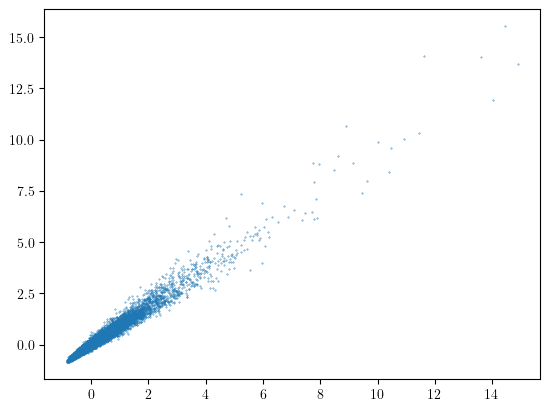

In [6]:
pl.figure()
# pl.scatter(df_q['density_cic_unpad_combined'].flatten()[::100], df_p['density_cic_unpad_combined'].flatten()[::100], s=0.1)
pl.scatter(df_q['density_cic_unpad_combined'].flatten()[::100], df_p.flatten()[::100], s=0.1)


In [16]:
import pickle as pk
df_q_f = pk.load(open('/mnt/ceph/users/spandey/Quijote/data_NGP_self/0/density_HR_full_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 
df_p_f = pk.load(open('/mnt/ceph/users/spandey/Quijote/data_NGP_self/fastpm/0/density_full_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk','rb'))



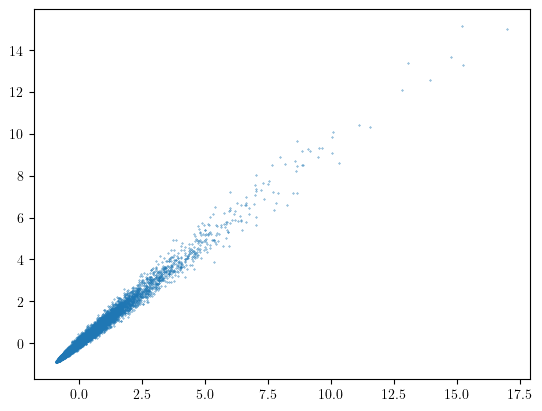

In [17]:
pl.figure()
pl.scatter(df_q_f['density_cic_unpad_combined'].flatten()[::100], df_p_f['density_cic_unpad_combined'].flatten()[::100], s=0.1)



